In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
from tqdm import tqdm

In [2]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import numpy as np

class SimpleDataset(Dataset):
    def __init__(self, addr, img_addr, transform=None):
        self.file_name = sorted(os.listdir(addr))
        self.img_addr = img_addr
        self.addr = addr
        self.transform = transform

    def __len__(self):
        return len(self.file_name)

    def __getitem__(self, idx):
        features = np.array(pd.read_csv(os.path.join(self.addr, self.file_name[idx], self.file_name[idx] + '.csv')).iloc[:, 5:])
        img_path = os.path.join(self.img_addr, self.file_name[idx] + '.jpg')
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        targ = int(self.file_name[idx].split('_')[-1])  # Convert target to integer

        return torch.tensor(features).squeeze(0).float(), img, targ

# Transformation for images to resize and normalize for ResNet18
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to fit ResNet18 input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet18
])

# Example usage:
# dataset = SimpleDataset(addr='path_to_csv_files', img_addr='path_to_images', transform=image_transform)


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
addr =    r"F:\Frames\extracted\Train"
img_addr = r"F:\Frames\new_dataset\Train_Frames\Train_Frames"
train = SimpleDataset(addr,img_addr, transform=image_transform)

In [4]:
addr =    r"F:\Frames\extracted\Test"
img_addr = r"F:\Frames\new_dataset\Test_Frames\Test_Frames"
test = SimpleDataset(addr,img_addr,transform=image_transform)

In [5]:

addr =    r"F:\Frames\extracted\Val"
img_addr = r"F:\Frames\new_dataset\Validation_Frames\Validation_Frames"
val = SimpleDataset(addr,img_addr, transform=image_transform)

In [6]:
from torch.utils.data import DataLoader

batch_size = 64  # You can adjust this according to your system's memory capacity

# Create data loaders
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

In [7]:
import torch.nn.functional as F
import torchvision.models as models
import torch.nn as nn
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        # Load pre-trained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)
        # Change the output layer to match the number of classes in your dataset
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

        # Define additional fully connected layers
        self.fc1 = nn.Linear(713, 32)  # Adding 714 for additional features
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, num_classes)

    def forward(self, features, images):
        # Extract features from images using ResNet18
        img_features = self.resnet(images)
        # print("img_features",img_features.shape)
        # print("features",features.shape)
        # Concatenate image features with additional features
        combined_features = torch.cat((img_features, features), dim=1)

        # Pass through additional fully connected layers
        x = F.relu(self.fc1(combined_features))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Example usage:
# Define the number of classes in your dataset
num_classes = 4  # Example value, replace with the actual number of classes
model = MyModel(num_classes)


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your model, optimizer, loss function, and other parameters
num_classes = 4  # Example value, replace with the actual number of classes

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 6

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap train_loader with tqdm
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Train')
    
    for features, images, labels in train_loader_iter:
        features, images, labels = features.to(device), images.to(device), labels.to(device)  # Move to GPU
        optimizer.zero_grad()
        # Forward pass
        outputs = model(features, images)
        # Calculate loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update tqdm description
        train_loader_iter.set_postfix(loss=loss.item())
    
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    
    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap val_loader with tqdm
    val_loader_iter = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation')
    
    with torch.no_grad():
        for features, images, labels in val_loader_iter:
            features, images, labels = features.to(device), images.to(device), labels.to(device)  # Move to GPU
            # Forward pass
            outputs = model(features, images)
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Update statistics
            running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update tqdm description
            val_loader_iter.set_postfix(loss=loss.item())
    
    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/6, Validation: 100%|██████████| 269/269 [07:01<00:00,  1.57s/it, loss=1.11] 


Epoch 1/6, Train Loss: 1.1429, Train Accuracy: 45.08%, Validation Loss: 1.0399, Validation Accuracy: 36.34%


Epoch 2/6, Validation: 100%|██████████| 269/269 [06:29<00:00,  1.45s/it, loss=1.12] 


Epoch 2/6, Train Loss: 0.8931, Train Accuracy: 50.29%, Validation Loss: 1.0232, Validation Accuracy: 53.02%


Epoch 3/6, Validation: 100%|██████████| 269/269 [06:22<00:00,  1.42s/it, loss=1.12] 


Epoch 3/6, Train Loss: 0.8676, Train Accuracy: 50.52%, Validation Loss: 1.0227, Validation Accuracy: 53.02%


Epoch 4/6, Validation: 100%|██████████| 269/269 [06:20<00:00,  1.41s/it, loss=1.13] 


Epoch 4/6, Train Loss: 0.8609, Train Accuracy: 50.52%, Validation Loss: 1.0233, Validation Accuracy: 53.02%


Epoch 5/6, Validation: 100%|██████████| 269/269 [06:20<00:00,  1.41s/it, loss=1.13] 


Epoch 5/6, Train Loss: 0.8584, Train Accuracy: 50.52%, Validation Loss: 1.0234, Validation Accuracy: 53.02%


Epoch 6/6, Validation: 100%|██████████| 269/269 [06:18<00:00,  1.41s/it, loss=1.13] 

Epoch 6/6, Train Loss: 0.8575, Train Accuracy: 50.52%, Validation Loss: 1.0243, Validation Accuracy: 53.02%


In [12]:
# # Define the path where the model is saved
# model_path = r"F:\RESTCN_CODE\frame-feature.pth"


# # Save the model
# torch.save(model.state_dict(), model_path)
# Define your model architecture
# Example:
# model = YourModelClass()

# Load the saved model parameters
# model.load_state_dict(torch.load(model_path))

# It's important to call model.eval() after loading the model
# if you're going to use it for inference
# model.eval()


Testing: 100%|██████████| 279/279 [06:33<00:00,  1.41s/it]

Test Accuracy: 0.49
Test F1 Score: 0.17
Confusion Matrix:
[[   0    0   40    0]
 [   0    0  840    0]
 [   0    0 8820    0]
 [   0    0 8140    0]]


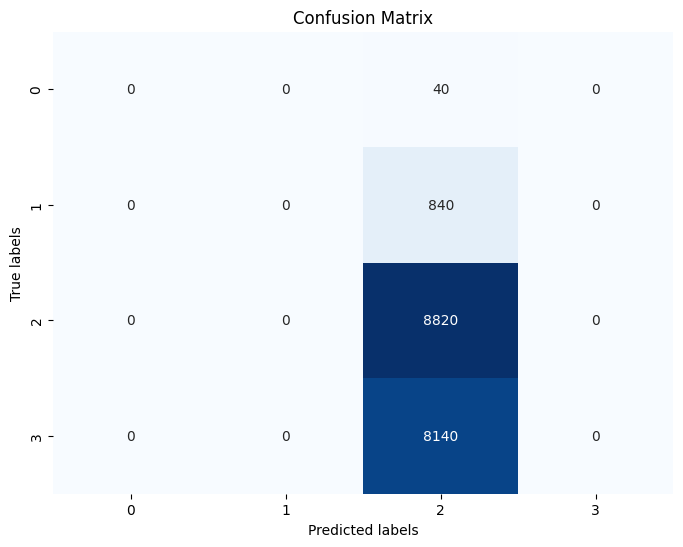

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Testing loop
model.eval()
predictions = []
true_labels = []

# Wrap test_loader with tqdm
test_loader_iter = tqdm(test_loader, desc=f'Testing')

with torch.no_grad():
    for features, images, labels in test_loader_iter:
        features, images, labels = features.to(device), images.to(device), labels.to(device)  # Move to GPU
        # Forward pass
        outputs = model(features, images)
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        # Collect predictions and true labels
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(true_labels, predictions)
# Calculate F1 score
test_f1_score = f1_score(true_labels, predictions, average='macro')
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test F1 Score: {test_f1_score:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
